In [1]:
import networkx as nx

# create graph
G = nx.Graph()

# add nodes
n = 32
nodes = list(range(1,n+1))
G.add_nodes_from(nodes)

# add edges
squares = [ i*i for i in range(2,8)]
for i in G.nodes:
    for s in squares:
        r = s - i
        if i < r and r<=32:
            G.add_edge(i,r)

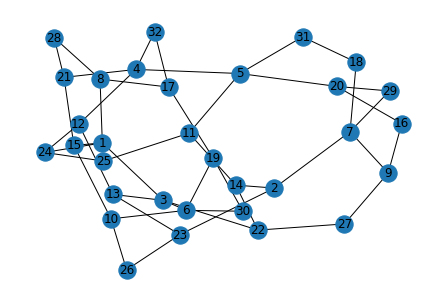

In [2]:
nx.draw(G, with_labels=True)

In [3]:
import gurobipy as gp
from gurobipy import GRB

# start with the 2-matching relaxation
# Create model object
m = gp.Model()

# Create variable for each edge
x = m.addVars( G.edges, vtype=GRB.BINARY )

# Add constraint for each node
m.addConstrs( gp.quicksum( x[e] for e in G.edges if e in G.edges(i)  ) == 2 for i in G.nodes )

m.update()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-09


In [4]:
# create a function to separate the subtour elimination constraints
def subtour_elimination(m, where):
    
    # check if LP relaxation at this branch-and-bound node has an integer solution
    if where == GRB.Callback.MIPSOL: 
        
        # retrieve the LP solution
        xval = m.cbGetSolution(m._x)
        
        # which edges are selected?
        tour_edges = [ e for e in m._G.edges if xval[e] > 0.5 ]
        
        # for each subtour, add a constraint
        for component in nx.connected_components( m._G.edge_subgraph( tour_edges ) ):
            
            if len(component) <= m._G.number_of_nodes() / 2:
                
                inner_edges = [ (i,j) for (i,j) in m._G.edges if i in component and j in component ]
                m.cbLazy( gp.quicksum( m._x[e] for e in inner_edges ) <= len(component) - 1 )

In [5]:
# optimize with subtour elimination constraints in callback
m.Params.LazyConstraints = 1
m._x = x
m._G = G
m._callback = subtour_elimination
m.optimize(m._callback)

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 32 rows, 46 columns and 92 nonzeros
Model fingerprint: 0xe2e03bc3
Variable types: 0 continuous, 46 integer (46 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve removed 30 rows and 41 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 6 nonzeros
Variable types: 0 continuous, 5 integer (5 binary)

Root relaxation: objective 0.000000e+00, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    3          -   

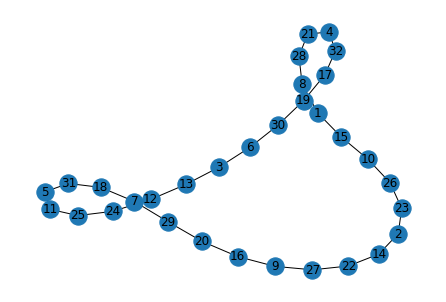

In [6]:
chosen_edges = [ e for e in G.edges if x[e].x > 0.5 ]
nx.draw(G.edge_subgraph(chosen_edges), with_labels=True)